<h3 align="right">Felix Filipi</h3>
<h3 align="right">2301877590</h3>

<h1 align="center"> Computer Vision </h1>
<h2 align="center"> Image Stitching </h2>

<b> Here, we are asked to create one panoramic image using image stitching technique. Clearly write the algorithm you followed, implement your respective algorithm in python notebook and show the final combined image. </b>

We were asked to create one panoramic image, but I want to know which algorithm works best for image stitching. So, I will try to implement several tweaks on image stitching, and here are several approaches that will be used:

1. Using orb and knn matcher
2. Using orb and bfmatcher
3. Using sift and knn matcher

Let's jump to the code. First, we need to import several library

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Now, as I've said earlier, I want to know which approach will give the best result for image stitching. So, we need to create several functions for each approach and implement It in our work.

In [2]:
def load_images(path):
    img = cv2.imread(path)
    return img

# try to implement feature matching using orb, and knn matcher
def orb_knn_matching(first_img, second_img):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(first_img, None)
    keypoints2, descriptors2 = orb.detectAndCompute(second_img, None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher()

    # knn Match descriptors.
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good = []
    for m in matches:
        if m[0].distance < 0.7 * m[1].distance:
            good.append(m)
            matches = np.asarray(good)

    src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches[:,0]]).reshape(-1,1,2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches[:,0]]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        
    return M, mask

# try to implement feature matching using orb, and bf matcher
def orb_bf_matching(first_img, second_img):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(first_img, None)
    keypoints2, descriptors2 = orb.detectAndCompute(second_img, None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Brute Force Match.
    matches = bf.match(descriptors1,descriptors2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        
    return M, mask

# try to implement feature matching using sift, and knn matcher
def sift_knn_matching(first_img, second_img):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(first_img, None)
    keypoints2, descriptors2 = sift.detectAndCompute(second_img, None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher()

    # knn Match descriptors.
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    good = []
    for m in matches:
        if m[0].distance < 0.7 * m[1].distance:
            good.append(m)
            matches = np.asarray(good)

    src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches[:,0]]).reshape(-1,1,2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches[:,0]]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        
    return M, mask

def image_wrapper(first_img, second_img, M):
    
    # define width and height of image 
    first_img_width = first_img.shape[1]
    first_img_height = first_img.shape[0]
    second_img_width = second_img.shape[1]
    second_img_height = second_img.shape[0]
    
    # wrap image
    wrapper = cv2.warpPerspective(first_img, M, (first_img_width + second_img_width, second_img_height))
    
    return wrapper

def stitch_image(wrapped, img):
    wrapped[0:img.shape[0], 0:img.shape[1]] = img
    return wrapped
    
def trim(img):
    if not np.sum(img[:,-1]):
        return trim(img[:,:-2])    
    return img

def visualize(img_list, title_list):
    plt.figure(figsize=(15,15))
    for i in range(len(img_list)):
        plt.subplot(5,3,i+1)
        plt.imshow(cv2.cvtColor(img_list[i], cv2.COLOR_BGR2RGB))
        plt.xticks([]), plt.yticks([])
        plt.title(title_list[i])

We've created each function that we need for this section. Let's try to implement image stitching for each approach.

First, load each images

In [3]:
img_a = load_images('1a.jpg')
img_b = load_images('1b.jpg')
img_c = load_images('1c.jpg')

Do image matching for each approach

In [4]:
M1, mask1 = orb_knn_matching(img_b,img_a)
M2, mask2 = orb_bf_matching(img_b, img_a)
M3, mask3 = sift_knn_matching(img_b,img_a)

Wrapper for each apporach

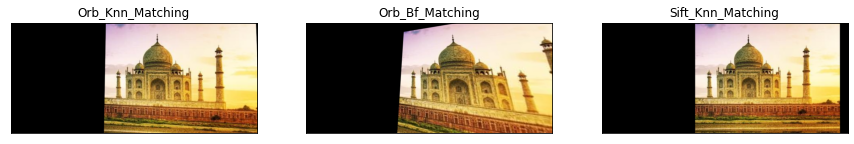

In [5]:
wrapped_1 = image_wrapper(img_b,img_a, M1)
wrapped_2 = image_wrapper(img_b,img_a, M2)
wrapped_3 = image_wrapper(img_b,img_a, M3)

wrapped_img = [wrapped_1, wrapped_2, wrapped_3]
wrapped_title = ['Orb_Knn_Matching', 'Orb_Bf_Matching','Sift_Knn_Matching']
visualize(wrapped_img, wrapped_title)

As we can see here, this 3 approach return different result each other. But which one will return best? does it Orb with knn matcher? Let's find it out.

Call the stitch function

In [6]:
stitched_image_1 = stitch_image(wrapped_1, img_a)
stitched_image_2 = stitch_image(wrapped_2, img_a)
stitched_image_3 = stitch_image(wrapped_3, img_a)

In [7]:
stitched_image_1 = trim(stitched_image_1)
stitched_image_2 = trim(stitched_image_2)
stitched_image_3 = trim(stitched_image_3)

Visualize it

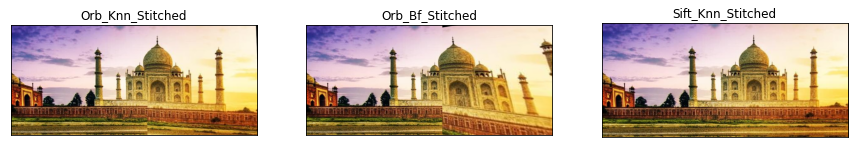

In [8]:
stitched_images = [stitched_image_1,stitched_image_2, stitched_image_3]
stitched_title = ['Orb_Knn_Stitched', 'Orb_Bf_Stitched','Sift_Knn_Stitched']
visualize(stitched_images, stitched_title)

So, as we can see here, Orb matcher using knn not return best stitch. Meanwhile Sift using knn return the best one. 

<b>From this result we can see several things:</b>

1. Sift matcher perform better than orb.
2. Knn matcher perform better than Bf matcher.
3. The best approach for image stitching is sift mathcer using knn to stitch the images.

Now, we've seen which approach do the best. Let's stitch the other images to see the result

In [9]:
M4, mask4 = orb_knn_matching(img_c,stitched_image_1)
M5, mask5 = orb_bf_matching(img_c,stitched_image_2)
M6, mask6 = sift_knn_matching(img_c,stitched_image_3)

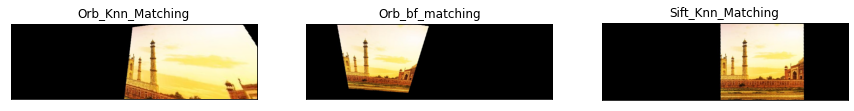

In [10]:
wrapped_4 = image_wrapper(img_c,stitched_image_1, M4)
wrapped_5 = image_wrapper(img_c,stitched_image_2, M5)
wrapped_6 = image_wrapper(img_c,stitched_image_3, M6)

wrapped_img = [wrapped_4,wrapped_5,wrapped_6]
wrapped_title = ['Orb_Knn_Matching','Orb_bf_matching','Sift_Knn_Matching']
visualize(wrapped_img, wrapped_title)

In [11]:
stitched_image_4 = stitch_image(wrapped_4, stitched_image_1)
stitched_image_5 = stitch_image(wrapped_5, stitched_image_2)
stitched_image_6 = stitch_image(wrapped_6, stitched_image_3)

In [12]:
stitched_image_4 = trim(stitched_image_4)
stitched_image_5 = trim(stitched_image_5)
stitched_image_6 = trim(stitched_image_6)

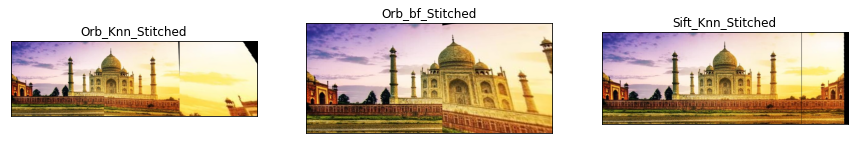

In [13]:
stitched_images = [stitched_image_4, stitched_image_5, stitched_image_6]
stitched_title = ['Orb_Knn_Stitched','Orb_bf_Stitched','Sift_Knn_Stitched']
visualize(stitched_images, stitched_title)

 <h2>Here I'm trying to find out which approach will generate the best image-stitching and now as we can see here, sift method using knn return the best image stitching. Thanks for watching